In [1]:
import joblib
import click
import json
import time
import os
import itertools
import collections.abc
import sys
from tqdm import tqdm
# !{sys.executable} -m pip install pylatexenc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error,r2_score
os.environ["OMP_NUM_THREADS"] = "12"
from scipy.optimize import minimize
# Qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Parameter, ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeQuebec

In [2]:
def mitarai(quantumcircuit,num_wires,paramname='x'):
    # encoding as proposed by Mitarai et al.
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_idx = i % num_features  # Calculate the feature index using modulo
        quantumcircuit.ry(np.arcsin(features[feature_idx * 2]), i)
        quantumcircuit.rz(np.arccos(features[feature_idx * 2 + 1] ** 2), i)



def entangle_cnot(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cnot gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cx(i, 0)
        else:
            quantumcircuit.cx(i, i+1)


def entangle_cz(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cz gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cz(i, 0)
        else:
            quantumcircuit.cz(i, i+1)


def HardwareEfficient(quantumcircuit,num_wires):
    parameters = ParameterVector('theta',num_wires*3)
    for qubit in range(num_wires):
        quantumcircuit.rx(parameters[qubit * 3], qubit)  
        quantumcircuit.rz(parameters[qubit * 3 + 1], qubit)  
        quantumcircuit.rx(parameters[qubit * 3 + 2], qubit)  
    entangle_cnot(quantumcircuit,num_wires)



In [3]:
def circuit(nqubits):
    qc = QuantumCircuit(nqubits)
    mitarai(qc,nqubits)
    entangle_cz(qc,nqubits)
    qc.barrier()
    mitarai(qc,nqubits,paramname='x1')
    entangle_cz(qc,num_qubits)
    qc.barrier()
    HardwareEfficient(qc,nqubits)
    qc.barrier()
    return qc

In [4]:
class regressor:
    def __init__(self,
                 n_qubits,
                 optimizer: str = 'COBYLA',
                 tol: float = 1e-8,
                 postprocess: str = None,
                 error_mitigation=None,
                 scale_factors: list = None,
                 f: float = 1.,
                 alpha: float = 0.,
                 beta: float = 0,
                 batch_size: int=None,
                 njobs: int=None,                 
                 device='statevector',
                 shots=None,
                 max_iterations=100):
        self.device = device
        self.shots = shots
        self.circuit = circuit(num_qubits)
        self.max_iterations = max_iterations
        self.n_qubits = n_qubits
        self.hyperparameters = {'f': f, 'alpha': alpha, 'beta': beta}
        if scale_factors is None:
            scale_factors = [1, 3, 5]
        self.callback_interval = None
        self.x = None
        self.y = None
        self.params = None
        self._batch_size = batch_size
        self.error_mitigation = error_mitigation
        if postprocess == 'None':
            postprocess = None
        self.postprocess = postprocess
        self._set_device()
        self._set_optimizer(optimizer)
        self._tol = tol
        self.fit_count = 0
        self.cached_results = {}
        self.njobs = njobs 
        print(self.njobs)
        os.environ["OMP_NUM_THREADS"] = str(self.njobs)
        print(os.environ["OMP_NUM_THREADS"])        
        observables_labels = ''.join(['I']*(self.n_qubits-1))+'Z'
        observables = [SparsePauliOp(observables_labels)]
        self.mapped_observables = [observable.apply_layout(self.circuit.layout) for observable in observables]
        
    def _set_device(self):
        if self.device=='real':
            service = QiskitRuntimeService(channel="ibm_quantum", instance='pinq-quebec-hub/univ-toronto/default')
            self._backend = service.least_busy(operational=True, simulator=False, min_num_qubits=self.n_qubits)
            self.estimator = Estimator(mode=backend)
            
            if self.shots==None:
                self.estimator.options.default_shots = 1024.0
            else:
                self.estimator.options.default_shots = self.shots            
            

            if self.error_mitigation == 'TREX':
                self.estimator.options.resilience_level = 1
            else:
                self.estimator.options.resilience_level = 0
                
        elif self.device == "fake":
            self._backend = FakeQuebec()
            target = self._backend.target
            pm = generate_preset_pass_manager(target=target)
            if self.shots==None:
                self.estimator.options.default_shots = 1024.0
            else:
                self.estimator.options.default_shots = self.shots            
            
            if self.error_mitigation == 'TREX':
                self.estimator.options.resilience_level = 1
            else:
                self.estimator.options.resilience_level = 0
                
        elif self.device == 'statevector':
            self.estimator = StatevectorEstimator()
            

                
    def _map_features(self,X):
        if len(X)==1:
            featparams = dict([(i,X.item()) for idx,i in enumerate(self.circuit.parameters) if 'x' in i.name])
        else:
            featparams = dict([(i,X[idx % num_qubits]) for idx,i in enumerate(self.circuit.parameters) if 'x' in i.name])
        return featparams
    
    def _assign_parameters(self,parameters):
        parameter_dict = dict(zip([i for i in self.circuit.parameters if 'theta' in i.name],parameters.flatten()))        
        return parameter_dict
        

            
    def _cost_wrapper(self, parameters):
        # caches the results from the cost function, so they don't have to be recalculated if they get called again i.e.
        # during the callback function for logging.
        param_hash = hash(parameters.data.tobytes())
        if param_hash in self.cached_results:
            cost = self.cached_results[param_hash]
        else:
            cost = self._cost(parameters)
            self.cached_results[param_hash] = cost
        print('GMJ Cost wrapper',cost,parameters)
        return cost                   

    def _save_partial_state(self, param_vector, force=False):
        # saves every call to a bin file able to be loaded later by calling fit with load_state set to filename
        interval = self.callback_interval
        if interval is None:
            interval = 5
        if self.fit_count % interval == 0 or force:
            partial_results = {
                'parameters': param_vector,
                'iterations': self.fit_count
            }
            if force is True and os.path.exists('partial_state_model.bin'):
                outfile = 'final_state_model.bin'
                os.remove('partial_state_model.bin')
            else:
                outfile = 'partial_state_model.bin'
            joblib.dump(partial_results, outfile)
    
    def _cost(self, parameters):
        pred = self.predict(self.x, params=parameters)
        base_cost = mean_squared_error(self.y, pred)    
        return base_cost

    def _load_partial_state(self, infile):
        print('Loading partial state from file ' + infile)
        partial_state = joblib.load(infile)
        if type(partial_state) == dict:
            param_vector = partial_state['parameters']
            iteration = partial_state['iterations']
            print('Loaded parameter_vector as', param_vector)
            return param_vector, iteration
        else:
            print('Outdated partial file detected! Unexpected behaviour may occur.')
            param_vector = partial_state
            print('Loaded parameter_vector as', param_vector)
        return param_vector, 0

    def fit(self, x, y, initial_parameters=None, detailed_results=False, load_state=None, callback_interval=None):
        """
        Fits the current model to the given x and y data. If no initial parameters are given then random ones will be
        chosen. Optimal parameters are stored in the model for use in predict and returned in this function.

        :param x: np.array
            x data to fit
        :param y: np.array
            y data to fit
        :param initial_parameters: list, optional
            initial parameters to start optimizer
        :param detailed_results: bool, optional
            whether to return detailed results of optimization or just parameters
        :param load_state: str, optional
            file to load partial fit data from
        :param callback_interval: int, optional
            how often to save the optimization steps to file
        :return:
            returns the optimal parameters found by optimizer. If detailed_results=True and optimizer is scipy, then
            will be of type scipy optimizer results stored in dictionary.
        """
        self.fit_count = 0
        with open('model_log.csv', 'w') as outfile:
            outfile.write('Time,Iteration,Cost,Parameters')
            outfile.write('\n')
        self.callback_interval = callback_interval

        if load_state is not None:
            param_vector, self.fit_count = self._load_partial_state(load_state)
            initial_parameters = param_vector
        elif initial_parameters is None:
            num_params = self._num_params()
            generator = np.random.default_rng(12958234)
            initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
            if self.postprocess is not None:
                additional_num_params = self.n_qubits
                additional_params = generator.uniform(-1, 1, additional_num_params)
                initial_parameters = np.concatenate((initial_parameters, additional_params))
        self.x = x
        self.y = y
        params = initial_parameters
        print(f'GMJ init params: {params}')
        if self.use_scipy:
            options = {
                'maxiter': self.max_iterations - self.fit_count,
                'tol': self._tol,
                'disp': True
            }
            if self.device == 'statevector':
                opt_result = minimize(self._cost_wrapper, x0=params, method=self.optimizer, callback=self._callback, options=options)
                self.params = opt_result['x']
            else:
                with Session(backend=self._backend) as session:            
                    opt_result = minimize(self._cost_wrapper, x0=params, method=self.optimizer, callback=self._callback, options=options)
                    self.params = opt_result['x']
            print(f'GMJ opt params: {self.params}')
            
        else:
            opt = qml.SPSAOptimizer(maxiter=self.max_iterations)
            cost = []
            if self.device == 'statevector':
                for idx,_ in enumerate(range(self.max_iterations)):
                    params, temp_cost = opt.step_and_cost(self._cost_wrapper, params)
                    cost.append(temp_cost)
                    self._callback(params)
    
                    if idx>0 and abs(cost[idx]-cost[idx-1])<=self._tol and abs(np.mean(cost[-3:])-temp_cost)<=self._tol:
                        print("Early stopping!")
                        break
                     
            else:
                with Session(backend=self._backend) as session:
                    for idx,_ in enumerate(range(self.max_iterations)):
                        params, temp_cost = opt.step_and_cost(self._cost_wrapper, params)
                        cost.append(temp_cost)
                        self._callback(params)
        
                        if idx>0 and abs(cost[idx]-cost[idx-1])<=self._tol and abs(np.mean(cost[-3:])-temp_cost)<=self._tol:
                            print("Early stopping!")
                            break
                        
            opt_result = [params, cost]
            self.params = params

        self._save_partial_state(params, force=True)
        if detailed_results:
            for key, value in opt_result.items():
                if type(value) is np.ndarray:
                    value = value.tolist()
                    for i, x in enumerate(value):
                        if type(x) is np.bool_:
                            value[i] = bool(x)
                    opt_result[key] = value
                elif type(value) is np.bool_:
                    value = bool(value)
                    opt_result[key] = value
            with open('detailed_results.json', 'w') as outfile:
                try:
                    json.dump(opt_result, outfile)
                except:
                    print('Could not dump detailed results. Not json serializable. ')
        return self.params

    def predict(self, x, params=None):
        """
        Predicts a set of output data given a set of input data x using the trained parameters found with fit

        :param x: np.array
            x data to predict outputs of in the model
        :param params: list
            optional parameters to use in prediction, used for internal cost functions.
        :raises ValueError:
            if fit is not first called then raises error explaining that the model must first be trained
        :return: np.ndarray
            predicted values corresponding to each datapoint in x
        """
        f = self.hyperparameters['f']
        print('GMJ predict params:',params)
        if params is None:
            # if no parameters are passed then we are predicting the fitted model, so we use the stored parameters.
            params = self.params

        if self.postprocess is None:
            return [f * self.qnode(features=features, parameters=params) for features in tqdm(x,desc="Predict")]
        else:
            return [np.dot(f * np.array(self.qnode(features=features, parameters=params[:-self.n_qubits])),params[-self.n_qubits:]) for features in x]


    def _callback(self, xk):
        cost_at_step = self._cost_wrapper(xk)
        if self.fit_count % 1 == 0:
            print(f'[{time.asctime()}]  Iteration number: {self.fit_count} with current cost as {cost_at_step} and '
                  f'parameters \n{xk}. ')
        filename = 'model_log.csv'
        log = f'{time.asctime()},{self.fit_count},{cost_at_step},{xk}'
        with open(filename, 'a') as outfile:
            outfile.write(log)
            outfile.write('\n')
        self.fit_count += 1
        self._save_partial_state(xk)    

    def _num_params(self):
        #  computes the number of parameters required for the implemented variational circuit
        num_params = len(self.circuit.parameters)
        return num_params
        
    def qnode(self,features,parameters):
        featparams = self._map_features(features)
        parameter_dict = self._assign_parameters(parameters)
        paramdict = parameter_dict | featparams
        # Ensure parameters from an optimizer or external calculation are strictly real
        paramdict = {p: float(np.real_if_close(d, tol=1e-7)) for p, d in paramdict.items()}
        
        self.circuit = self.circuit.assign_parameters(paramdict)
        job = self.estimator.run([(self.circuit, self.mapped_observables)])
        y_pred = job.result()[0].data.evs
        return y_pred

    def _set_optimizer(self, optimizer):
        #  sets the desired optimizer. SPSA is not available in scipy and has to be handled separately in fitting
        if optimizer == 'SPSA':
            self.use_scipy = False
            self.optimizer = optimizer
        else:
            self.use_scipy = True
            self.optimizer = optimizer

In [5]:
with open('linear_train.bin','rb') as f:
    train = joblib.load(f)

with open('linear_test.bin','rb') as f:
    test = joblib.load(f)

with open('linear_scaler.bin','rb') as f:
    scaler = joblib.load(f)
X_train, y_train = train['X'],train['y']
X_test, y_test = test['X'],test['y']


with open('PCA5_0.8_Morgan_train.bin','rb') as f:
    bse_train = joblib.load(f)

with open('PCA5_0.8_Morgan_test.bin','rb') as f:
    bse_test = joblib.load(f)

with open('PCA5_0.8_Morgan_scaler.bin','rb') as f:
    bse_scaler = joblib.load(f)

X_bse_train, y_bse_train = bse_train['X'],bse_train['y']
X_bse_test, y_bse_test = bse_test['X'],bse_test['y']


X_bse_train[np.isclose(X_bse_train,1)]=1
X_bse_train[np.isclose(X_bse_train,-1)]=-1

/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
def predict(params, ansatz, hamiltonian, estimator,X):
    num_qubits = ansatz.num_qubits
    if len(X)==1:
        featparams = dict([(i,X.item()) for idx,i in enumerate(ansatz.parameters) if 'x' in i.name])
    else:
        featparams = dict([(i,X[idx % num_qubits]) for idx,i in enumerate(ansatz.parameters) if 'x' in i.name])
    
    ansatz = ansatz.assign_parameters(featparams)    
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy

In [7]:
def cost_func(params, ansatz, hamiltonian, estimator,X,y):
    """Return estimate of energy from estimator

    Parameters:

        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    
    y_pred = np.array([predict(params, ansatz, hamiltonian, estimator,x) for x in X]).reshape(*y.shape)
    # print(y,y_pred)
    loss = mean_squared_error(y,y_pred)
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(loss)
    # print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {loss}]")

    return loss

In [8]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [9]:
num_qubits = 5
# X = X_bse_train[0:1].flatten()
# Y = y_bse_test[0:1]

# X,Y = X_bse_train, y_bse_train
X,Y = X_train, y_train

In [10]:
X.shape

(80, 1)

In [16]:
x0 = np.array([-2.8805814,2.25981614,-2.06241361,0.03610409,0.43163927,-3.3391198,3.49545026,2.07181879,0.88155993,-0.80296887,0.46024759,1.66736349 ,1.47045888,-1.72916796,0.0811196])

Iteration: 0 R2: 0.508793233075234 MSE: 0.16195944642980536


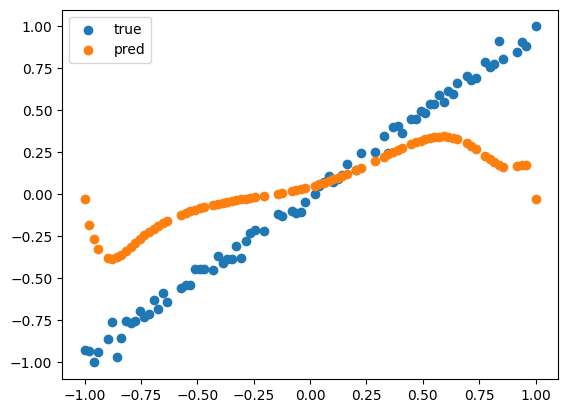

Iteration: 1 R2: 0.5250926978754648 MSE: 0.1565852283328633
Iteration: 2 R2: 0.5298184205981744 MSE: 0.15502707505060606
Iteration: 3 R2: 0.5302246760583964 MSE: 0.1548931255330565
Iteration: 4 R2: 0.5302407907568176 MSE: 0.15488781223566034
Iteration: 5 R2: 0.5302463053957569 MSE: 0.1548859939629288
Iteration: 6 R2: 0.5302467933213046 MSE: 0.15488583308535758
Iteration: 7 R2: 0.5302468575083661 MSE: 0.15488581192176287
Iteration: 8 R2: 0.5302468943455527 MSE: 0.15488579977589934
Iteration: 9 R2: 0.530246902339405 MSE: 0.15488579714018672
Iteration: 10 R2: 0.5302469099113333 MSE: 0.15488579464358973


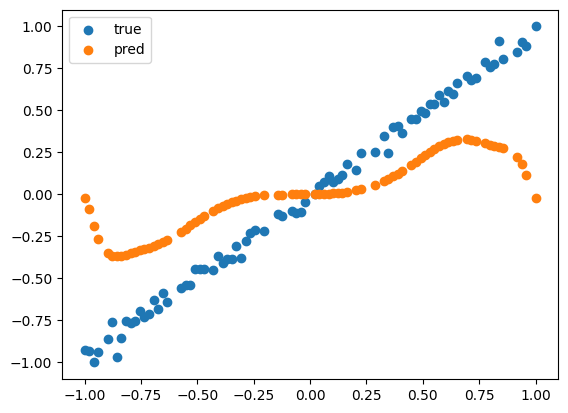

Iteration: 11 R2: 0.5302469125240088 MSE: 0.154885793782145
Iteration: 12 R2: 0.530246912524009 MSE: 0.15488579378214495
Iteration: 13 R2: 0.530246912524009 MSE: 0.15488579378214493
Iteration: 14 R2: 0.5302469161111427 MSE: 0.15488579259940435
Iteration: 15 R2: 0.5302469171597473 MSE: 0.15488579225366111
Iteration: 16 R2: 0.5302469190407909 MSE: 0.15488579163344818
Iteration: 17 R2: 0.5302469196659947 MSE: 0.1548857914273076
Iteration: 18 R2: 0.530246919958425 MSE: 0.15488579133088823
Iteration: 19 R2: 0.5302469202182718 MSE: 0.15488579124521218
Iteration: 20 R2: 0.5302469202182719 MSE: 0.15488579124521212


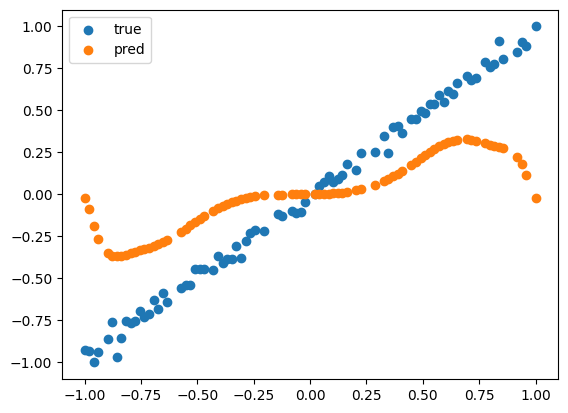

Iteration: 21 R2: 0.5302469202576454 MSE: 0.15488579123223004
Iteration: 22 R2: 0.5302469204715186 MSE: 0.1548857911617123
Iteration: 23 R2: 0.5302469216800249 MSE: 0.15488579076324666
Iteration: 24 R2: 0.530246923066555 MSE: 0.15488579030608346
Iteration: 25 R2: 0.5302469232308598 MSE: 0.15488579025190932
Iteration: 26 R2: 0.5302469240412084 MSE: 0.15488578998472322
Iteration: 27 R2: 0.530246924090383 MSE: 0.15488578996850952
Iteration: 28 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 29 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 30 R2: 0.5302469240903831 MSE: 0.1548857899685095


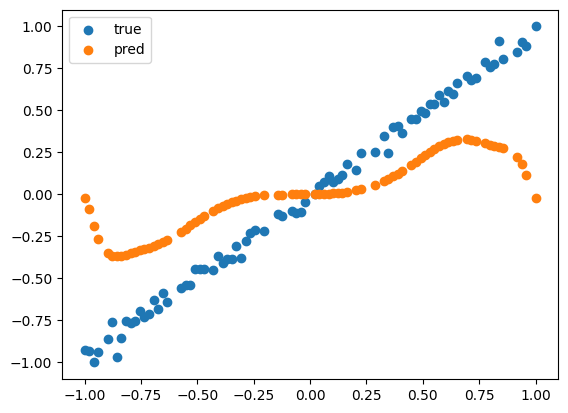

Iteration: 31 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 32 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 33 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 34 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 35 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 36 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 37 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 38 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 39 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 40 R2: 0.5302469240903831 MSE: 0.1548857899685095


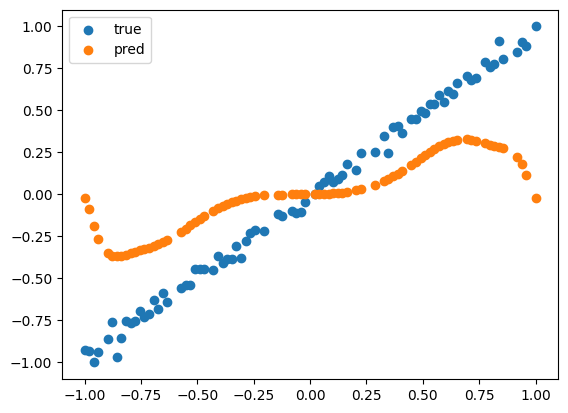

Iteration: 41 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 42 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 43 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 44 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 45 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 46 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 47 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 48 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 49 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 50 R2: 0.5302469240903831 MSE: 0.1548857899685095


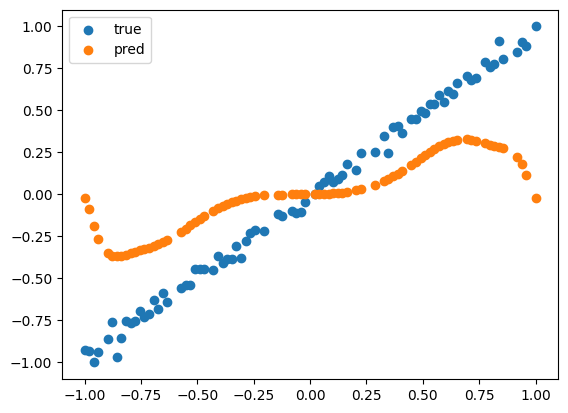

Iteration: 51 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 52 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 53 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 54 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 55 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 56 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 57 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 58 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 59 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 60 R2: 0.5302469240903831 MSE: 0.1548857899685095


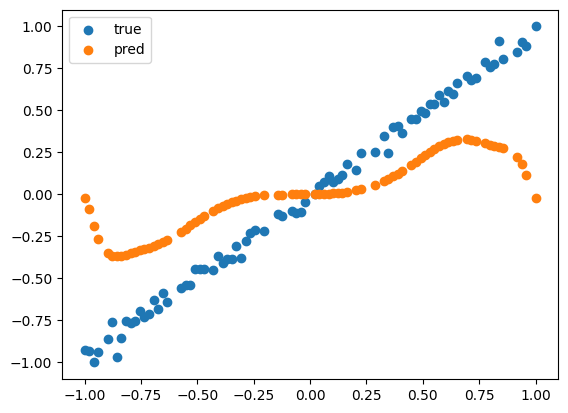

Iteration: 61 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 62 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 63 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 64 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 65 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 66 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 67 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 68 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 69 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 70 R2: 0.5302469240903831 MSE: 0.1548857899685095


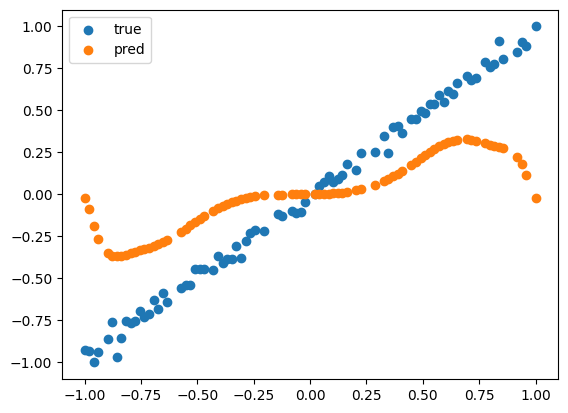

Iteration: 71 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 72 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 73 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 74 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 75 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 76 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 77 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 78 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 79 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 80 R2: 0.5302469240903831 MSE: 0.1548857899685095


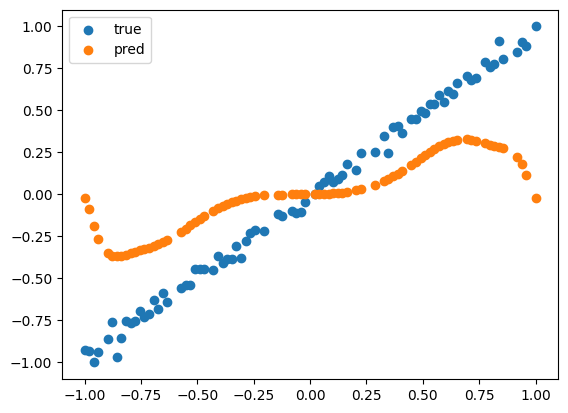

Iteration: 81 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 82 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 83 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 84 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 85 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 86 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 87 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 88 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 89 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 90 R2: 0.5302469240903831 MSE: 0.1548857899685095


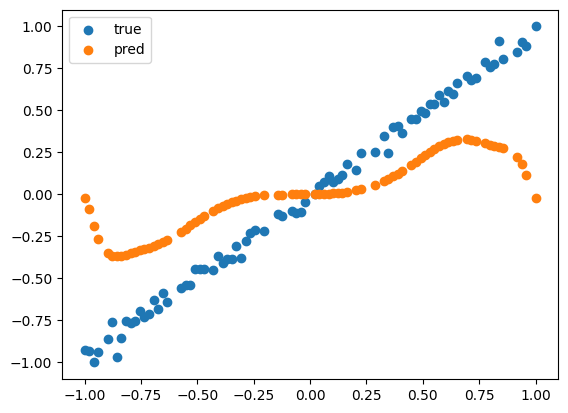

Iteration: 91 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 92 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 93 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 94 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 95 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 96 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 97 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 98 R2: 0.5302469240903831 MSE: 0.1548857899685095
Iteration: 99 R2: 0.5302469240903831 MSE: 0.1548857899685095


In [17]:
qc = circuit(num_qubits)
num_params = len([i for i in list(qc.parameters) if 'theta' in i.name])
# x0 = 2 * np.pi * np.random.random(num_params)
generator = np.random.default_rng(12958234)
# x0 = generator.uniform(-np.pi, np.pi, num_qubits*3).reshape(-1,)
# x0=np.array([-2.90335709,2.22986535,-2.00373979,-0.16646551,0.63465958,-2.72860048 ,2.66349506,2.2229548,1.7837882,-1.05017446,0.51676695,1.19521426 ,1.66007016,-1.56591128,0.73095999]).flatten()
# print(x0.shape)
estimator = StatevectorEstimator()





observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
observables = [SparsePauliOp(observables_labels)]
mapped_observables = [observable.apply_layout(qc.layout) for observable in observables]



# job = estimator.run([(qc, mapped_observables)])
# y_pred = job.result()[0].data.evs
scores = []
for i in range(100):
    cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }    
    res = minimize(
        cost_func,
        x0,
        args=(qc, mapped_observables, estimator,X,Y),
        method="cobyla", options={'maxiter':100}
)
    x0 = res.x

    y_pred = np.array([predict(x0,qc, mapped_observables, estimator,x) for x in X])
    r2 = r2_score(Y,y_pred)
    loss = mean_squared_error(Y,y_pred)
    print(f"Iteration: {i} R2: {r2} MSE: {loss}")
    scores.append((r2,loss))
    if i % 10 ==0:
        plt.scatter(X,Y,label='true')
        plt.scatter(X,y_pred,label='pred')
        plt.legend()
        plt.show()
    # plt.show()
# cost_func(x0,qc,mapped_observables,estimator)

In [ ]:
x0.shape

In [18]:
y_pred = np.array([predict(x0,qc, mapped_observables, estimator,x) for x in X])
r2_score(Y,y_pred)

0.5302469240903831

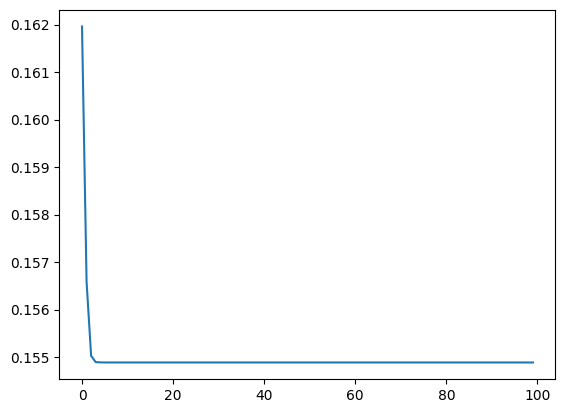

In [19]:
plt.plot(np.array(scores)[:,1])

In [ ]:
np.array(list(paramdict.values()))

In [ ]:
res

In [ ]:
all(cost_history_dict["prev_vector"] == res.x),cost_history_dict["iters"] == res.nfev

In [ ]:
model = regressor(5)

In [ ]:
model.fit(X_train[0:1],y_train[0:1])

In [ ]:
model.fit(X_train,y_train)

In [ ]:
y_train

In [ ]:
model.predict(X)

In [ ]:

qc = circuit(num_qubits)

observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
observables = [SparsePauliOp(observables_labels)]
mapped_observables = [observable.apply_layout(qc.layout) for observable in observables]
generator = np.random.default_rng(12958234)
angles = generator.uniform(-np.pi, np.pi, num_qubits*3).reshape(-1,3)



def predict(qc,X,parameters):
    parameter_dict = dict(zip([i for i in qc.parameters if 'theta' in i.name],parameters.flatten()))
    
    if len(X)==1:
        featparams = dict([(i,X.item()) for idx,i in enumerate(qc.parameters) if 'x' in i.name])
    else:
        featparams = dict([(i,X[idx % num_qubits]) for idx,i in enumerate(qc.parameters) if 'x' in i.name])
    
    
    paramdict = parameter_dict | featparams
    # Ensure parameters from an optimizer or external calculation are strictly real
    paramdict = {p: float(np.real_if_close(d, tol=1e-7)) for p, d in paramdict.items()}
    qc = qc.assign_parameters(paramdict)
    
    estimator = StatevectorEstimator()
    
    
    job = estimator.run([(qc, mapped_observables)])
    y_pred = job.result()[0].data.evs
    return y_pred

In [ ]:
minimize(predict, x0=angles.flatten(), args=(qc,X_train[0]), method='COBYLA')

In [ ]:
predict(qc,X_train[0],angles)

In [ ]:
[mean_squared_error(y,predict(qc,x,angles)) for x,y in zip(X_train,y_train)]